In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Given that after EDA, we know that the data contains no null values, no abnomalies 

# 1. 🔍 Preprocessing and Choosing the DL method

In [2]:
data = pd.read_csv('../Data/raw.csv')
data= data.drop(columns= ["Household_ID"])
df = data.copy()

In [10]:
print("Data types for each variable:")
print(df.dtypes, "\n")
print("Unique values of each variables:")
print(df.nunique())

Data types for each variable:
Region                object
Country               object
Energy_Source         object
Monthly_Usage_kWh    float64
Year                   int64
Household_Size         int64
Income_Level          object
Urban_Rural           object
Adoption_Year          int64
Subsidy_Received      object
Cost_Savings_USD     float64
dtype: object 

Unique values of each variables:
Region                 6
Country               25
Energy_Source          5
Monthly_Usage_kWh    995
Year                   5
Household_Size         8
Income_Level           3
Urban_Rural            2
Adoption_Year         15
Subsidy_Received       2
Cost_Savings_USD     989
dtype: int64


=> Country, Region, have a large number of unique values: 25 and 6

## a) Examine column "Country"

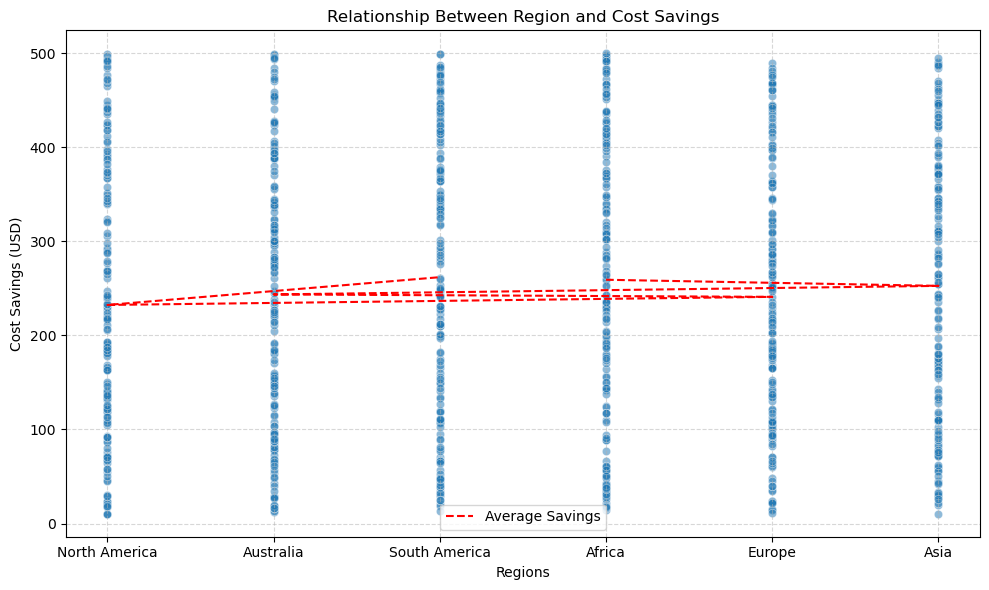

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns

# Columns to exclude from Label Encoding
excluded_cols = ["Energy_Source", "Urban_Rural", "Subsidy_Received","Income_Level"]


df['Income_Level'] = df['Income_Level'].map({'Low': 0, 'Middle': 1, 'High': 2})

# One-Hot Encode
df = pd.get_dummies(df, columns=["Energy_Source"], drop_first=True)
df = pd.get_dummies(df, columns=["Urban_Rural"], drop_first=True)
df = pd.get_dummies(df, columns=["Subsidy_Received"], drop_first=True)

plt.figure(figsize=(10, 6))
plt.scatter(df['Region'], df['Cost_Savings_USD'], alpha=0.5, edgecolors='w', linewidth=0.5)
avg_savings_by_regions = df.groupby('Region')['Cost_Savings_USD'].mean().reset_index()
plt.plot(avg_savings_by_regions['Region'], avg_savings_by_regions['Cost_Savings_USD'], color='red', linestyle='--', label='Average Savings')
plt.title('Relationship Between Region and Cost Savings')
plt.xlabel('Regions')
plt.ylabel('Cost Savings (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The range of cost savings considering every country is (200, 310)

=> can keep for further insights but keep it raw

If using one hot encoding => high dimensionality

if using label encoding => assign numerical significance to categorical variables

## b) Examine column Region -> remove this column

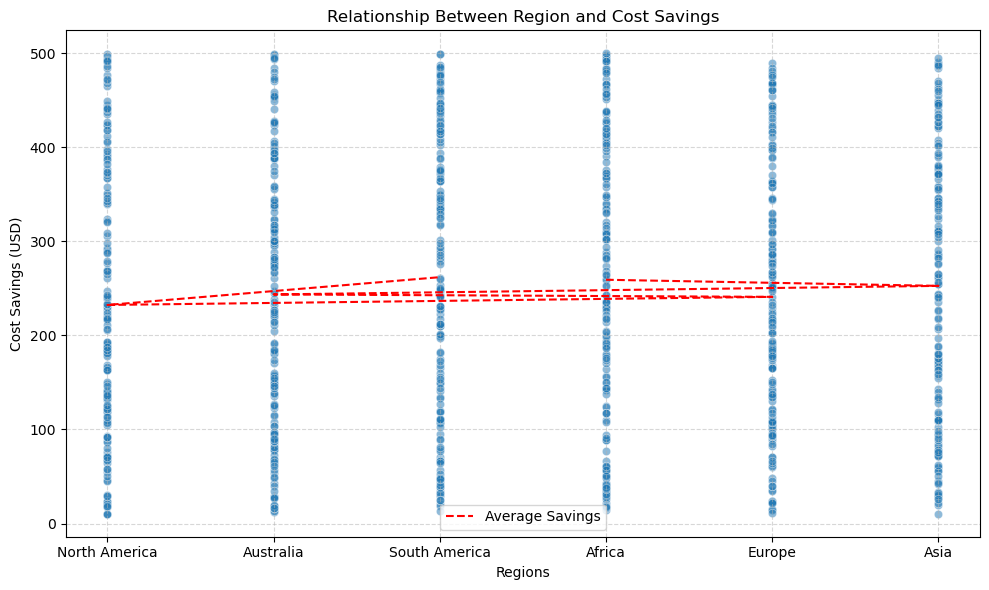

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Region'], df['Cost_Savings_USD'], alpha=0.5, edgecolors='w', linewidth=0.5)
avg_savings_by_regions = df.groupby('Region')['Cost_Savings_USD'].mean().reset_index()
plt.plot(avg_savings_by_regions['Region'], avg_savings_by_regions['Cost_Savings_USD'], color='red', linestyle='--', label='Average Savings')
plt.title('Relationship Between Region and Cost Savings')
plt.xlabel('Regions')
plt.ylabel('Cost Savings (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

=> The graph barely illustrates any significance among cost savings of regions => can remove Region

Families at South Africa & Africa have the tendency to save more money using renewable energy, but the difference among other regions is not considerable

## c) Choosing the DL method

### Examine the relationship between columns

Covariance matrix:


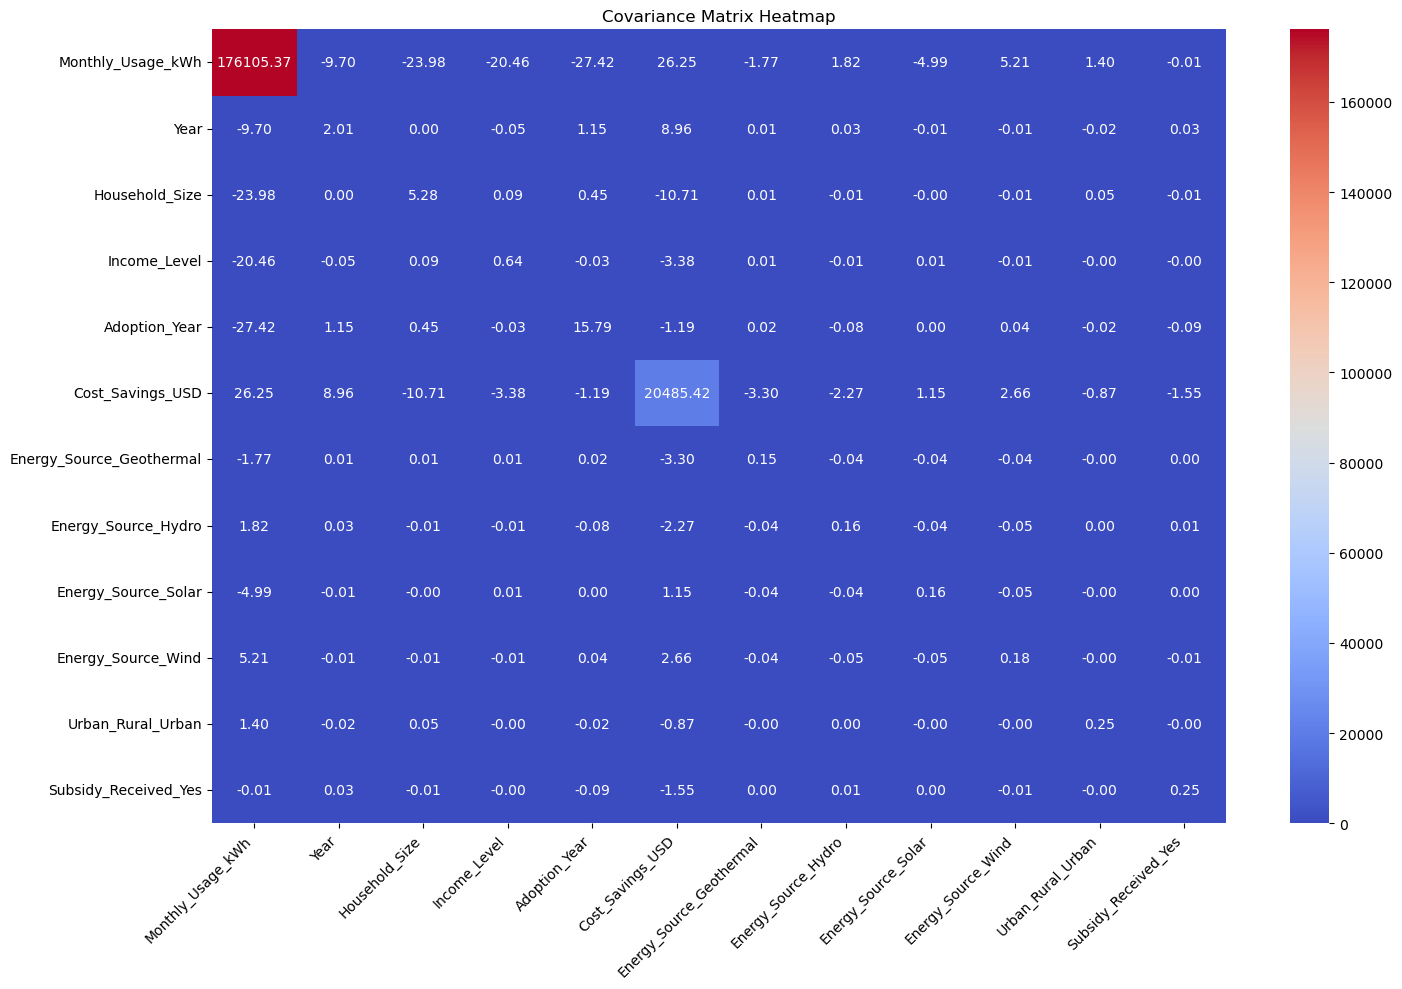

Correlation matrix:


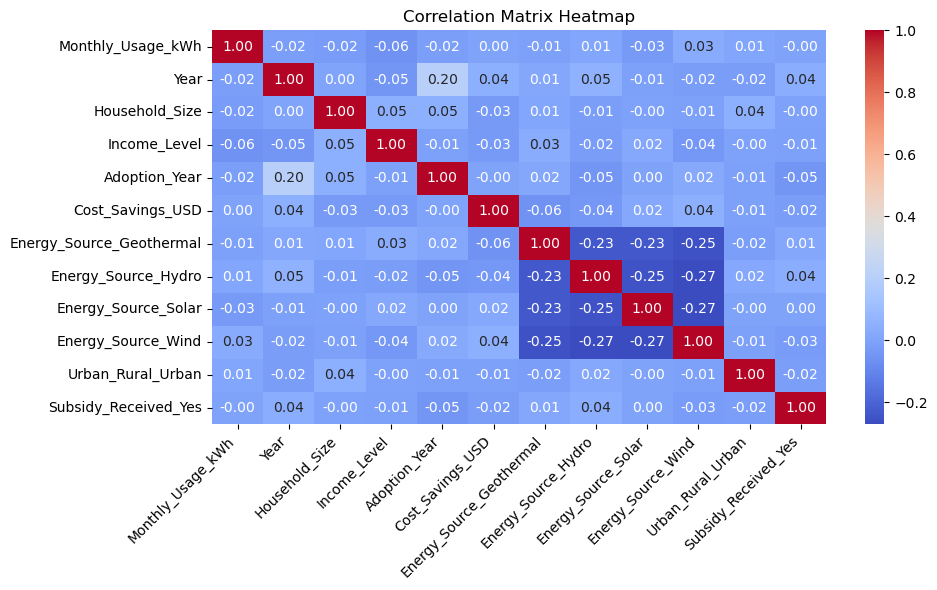

In [13]:
# Covariance matrix including categorical feature
print("Covariance matrix:")
heh= df.drop(columns= ["Country","Region"])
covar_matrix= heh.cov()
plt.figure(figsize=(15, 10))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Covariance Matrix Heatmap")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better fit
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()     
plt.show()


# Correlation matrix including categorical feature
print("Correlation matrix:")
corr_matrix= heh.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better fit
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()     
plt.show()

From 2 figures we can see that the relationships among variables are weak (Values in the correlation matrix is near to 0), the data can be largely affected by other factors

=> Supervised learning methods would not be effective

# 2. ⚙️ Clustering with K-Prototypes

We choose K-Prototypes, a combination of K-Means(numerical data) and K-Modes(categorial data)

This method forms clusters by comparing the difference between data point to group close points together.

- For Numerical data, it compares using the Euclidean distance (K-means)
- For categorial data, it compares number of mismatches between categorical values (K-Modes)

K-Prototypes assigns weights to both types of features and calculates a weighted distance metric to determine cluster assignments

=> This means we dont have to encode the 2 types of data separately


## a) Making Clusters

In [27]:
from kmodes.kprototypes import KPrototypes

df = data.copy()
df = df.drop(columns=["Region"])

# Get the indices of numerical and categorial columnns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_indexes = [df.columns.get_loc(col) for col in categorical_columns]

### i) Choosing the right number of clusters(K)

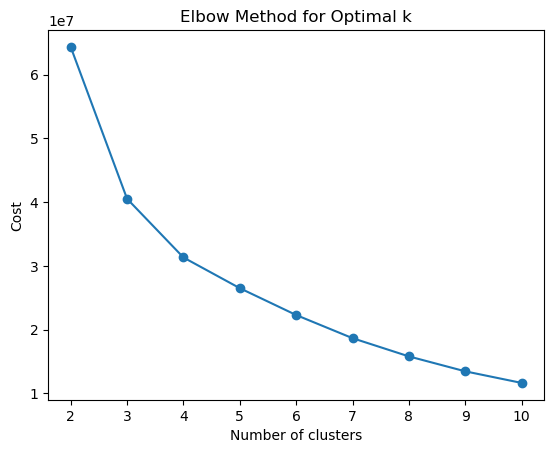

In [ ]:
# Comparing the cost w.r.t the number of clusters

costs = []
for k in range(2, 11):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    kp.fit_predict(df.to_numpy(), categorical=categorical_indexes)
    costs.append(kp.cost_)

plt.plot(range(2, 11), costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


==> We choose K=10 for the lower cost, higher number of k would further reduce the cost but lead to overfitting

### ii) Building the final model

In [ ]:
# Perform K-prototype clustering
kproto = KPrototypes(n_clusters=10, init='Cao', verbose=0)
clusters = kproto.fit_predict(df.to_numpy(), categorical=categorical_indexes)

## b) Displaying clusters info

In [15]:
numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns
# Find correct order of the columns name because kprototype change it 
correct_column_order = list(numerical_columns) + list(categorical_columns) 

# Turn clusters into DataFrame
centroids_df = pd.DataFrame(kproto.cluster_centroids_, columns=correct_column_order)

# Round up float data for certain columns
columns_to_round = ["Year", "Adoption_Year"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(0).astype(int)
columns_to_round = ["Monthly_Usage_kWh", "Cost_Savings_USD", "Household_Size"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(2)

# Display the clusters
centroids_df.index = [f'Cluster {i}' for i in range(kproto.n_clusters)]
centroids_df

,Monthly_Usage_kWh,Year,Household_Size,Adoption_Year,Cost_Savings_USD,Country,Energy_Source,Income_Level,Urban_Rural,Subsidy_Received
Cluster 0,1362.26,2022,4.30,2016,142.02,Mexico,Hydro,Middle,Rural,Yes
Cluster 1,842.02,2022,5.09,2016,140.65,New Zealand,Solar,Low,Urban,Yes
Cluster 2,693.05,2022,3.99,2016,389.80,Australia,Wind,Low,Urban,Yes
Cluster 3,551.55,2022,4.42,2016,121.07,Canada,Wind,High,Rural,Yes
Cluster 4,1329.01,2022,4.13,2016,390.39,China,Wind,Low,Rural,No
Cluster 5,1109.85,2022,4.43,2016,145.62,Australia,Wind,Middle,Urban,No
Cluster 6,983.17,2022,4.83,2016,397.54,Australia,Solar,Middle,Rural,No
Cluster 7,140.89,2022,4.48,2016,349.62,Canada,Wind,Low,Rural,No
Cluster 8,211.53,2022,4.64,2017,115.99,New Zealand,Solar,High,Rural,No
Cluster 9,392.67,2022,4.48,2016,362.72,New Zealand,Solar,Middle,Urban,Yes


## c) Evaluation

### i) Silhouette Score (numerical only)

In [24]:
from sklearn.metrics import silhouette_score

# Get cluster labels and numerical subset
labels = kproto.labels_
numerical_data = data.select_dtypes(include=['int64', 'float64'])

score = silhouette_score(numerical_data, labels)
print("Silhouette score ranges from -1 to 1; closer to 1 means well-separated clusters.\n")
print("Silhouette Score:", score)

Silhouette score ranges from -1 to 1; closer to 1 means well-separated clusters.

Silhouette Score: 0.393385780744911


### ii) Clusters distribution

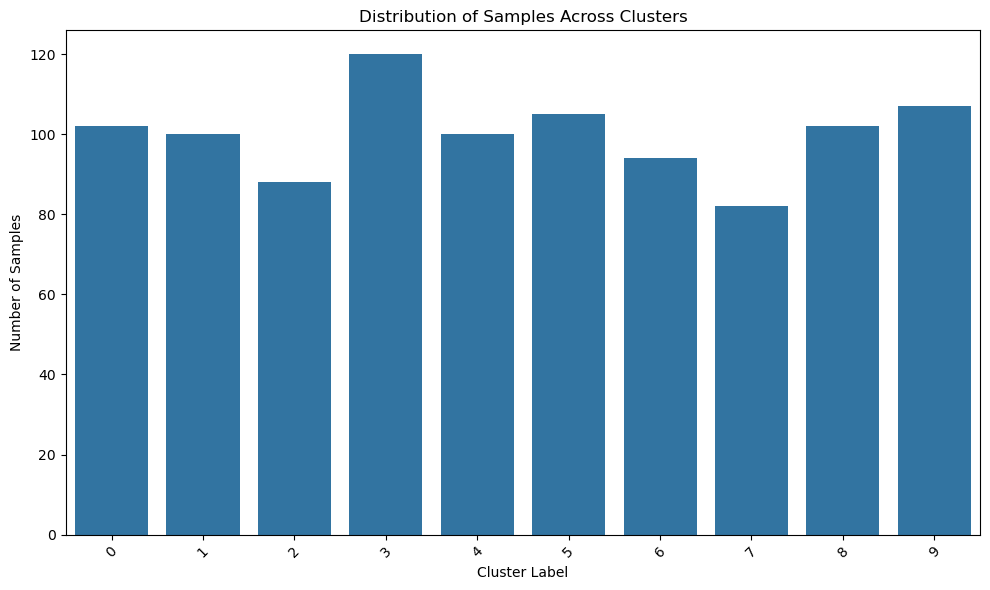

In [29]:
data['Cluster'] = labels

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=data)
plt.title("Distribution of Samples Across Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

==> A relatively balanced distribution

## d) Making predictions

In [17]:
# Assign a name for each cluster
cluster_labels = {
    0: "Heavy Users in Underserved Areas",
    1: "High Impact Rural Households",
    2: "Minimal Users with Strong Means",
    3: "Urban Subsidized Adopters",
    4: "Budget-Conscious Urban Beneficiaries",
    5: "Efficient Urban Savers",
    6: "High Consumers with Low Returns",
    7: "Frugal Households with High Gains",
    8: "Urban Energy Spenders",
    9: "Wealthy Subsidized Consumers"
}
columns = df.columns.tolist()


sample = pd.DataFrame([{
    "Monthly_Usage_kWh": 950.0,
    "Year": 2022,
    "Household_Size": 4.6,
    "Adoption_Year": 2017,
    "Cost_Savings_USD": 300.0,
    "Country": "Australia",
    "Energy_Source": "Solar",
    "Income_Level": "Middle",
    "Urban_Rural": "Urban",
    "Subsidy_Received": "Yes"
}])[columns]  # ensure correct column order

cluster_id = kproto.predict(sample.to_numpy(), categorical=categorical_indexes)[0]
user_label = cluster_labels[cluster_id]
print(f"Cluster {cluster_id}: {user_label}")

Cluster 6: High Consumers with Low Returns


## e) Saving the model

In [ ]:
# import pickle

# with open("K_Prototypes.pkl", "wb") as f:
#     pickle.dump(kproto, f)